# DISCLAIMER: Almost no finetuning

In [1]:
import pandas as pd
import numpy as np
from catboost import CatBoostClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from lightgbm import LGBMClassifier
from sklearn.metrics import f1_score
from imblearn.over_sampling import SMOTE
from collections import Counter
import warnings
warnings.filterwarnings("ignore")

Using TensorFlow backend.


# CATBOOST

### Pre-processing specific to CATBOOST

In [20]:
df_train = pd.read_csv("train_fNxu4vz.csv")
df_test = pd.read_csv("test_fjtUOL8.csv")

# Convert to numeric
df_train["Loan_Amount_Requested"] = df_train["Loan_Amount_Requested"].str.replace(",", "")
df_train["Loan_Amount_Requested"] = pd.to_numeric(df_train["Loan_Amount_Requested"])
df_test["Loan_Amount_Requested"] = df_test["Loan_Amount_Requested"].str.replace(",", "")
df_test["Loan_Amount_Requested"] = pd.to_numeric(df_test["Loan_Amount_Requested"])

# Fill NaN
df_train["Length_Employed"].fillna('NaN', inplace=True)
df_test["Length_Employed"].fillna('NaN', inplace=True)

df_train["Home_Owner"].fillna('NaN', inplace=True)
df_test["Home_Owner"].fillna('NaN', inplace=True)

df_train["Income_Verified"].fillna('NaN', inplace=True)
df_test["Income_Verified"].fillna('NaN', inplace=True)

df_train["Purpose_Of_Loan"].fillna('NaN', inplace=True)
df_test["Purpose_Of_Loan"].fillna('NaN', inplace=True)

df_train["Gender"].fillna('NaN', inplace=True)
df_test["Gender"].fillna('NaN', inplace=True)

# Drop loan ids
df_train = df_train.drop(["Loan_ID"], axis=1)
loan_ids = df_test["Loan_ID"].values
df_test = df_test.drop(["Loan_ID"], axis=1)

# Fill NaN with mean
df_train["Annual_Income"].fillna(df_train["Annual_Income"].mean(), inplace=True)
df_test["Annual_Income"].fillna(df_test["Annual_Income"].mean(), inplace=True)

# Assumption: If it is NaN, then user has no deliquency, so set with 0
df_train["Months_Since_Deliquency"].fillna(0, inplace=True)
df_test["Months_Since_Deliquency"].fillna(0, inplace=True)

# New feature
df_train["Number_Invalid_Acc"] = df_train["Total_Accounts"] - df_train["Number_Open_Accounts"]
df_test["Number_Invalid_Acc"] = df_test["Total_Accounts"] - df_test["Number_Open_Accounts"]

# New feature
df_train["Number_Years_To_Repay_Debt"] = df_train["Loan_Amount_Requested"]/df_train["Annual_Income"]
df_test["Number_Years_To_Repay_Debt"] = df_test["Loan_Amount_Requested"]/df_test["Annual_Income"]

df_train.head()

,Loan_Amount_Requested,Length_Employed,Home_Owner,Annual_Income,Income_Verified,Purpose_Of_Loan,Debt_To_Income,Inquiries_Last_6Mo,Months_Since_Deliquency,Number_Open_Accounts,Total_Accounts,Gender,Interest_Rate,Number_Invalid_Acc,Number_Years_To_Repay_Debt
0,7000,< 1 year,Rent,68000.000000,not verified,car,18.37,0,0.0,9,14,Female,1,5,0.102941
1,30000,4 years,Mortgage,73331.159434,VERIFIED - income,debt_consolidation,14.93,0,17.0,12,24,Female,3,12,0.409103
2,24725,7 years,Mortgage,75566.400000,VERIFIED - income source,debt_consolidation,15.88,0,0.0,12,16,Male,3,4,0.327196
3,16000,< 1 year,NaN,56160.000000,VERIFIED - income source,debt_consolidation,14.34,3,0.0,16,22,Male,3,6,0.284900
4,17000,8 years,Own,96000.000000,VERIFIED - income source,debt_consolidation,22.17,1,0.0,19,30,Female,1,11,0.177083


### Convert to X and Y

In [21]:
X_train, Y = df_train.drop(["Interest_Rate"], axis=1).values, df_train["Interest_Rate"].values
X_test = df_test.values

X_train.shape, Y.shape, X_test.shape

((164309, 14), (164309,), (109541, 14))

### Perform Validation

In [4]:
kfold, scores = KFold(n_splits=5, shuffle=True, random_state=0), list()
for train, test in kfold.split(X_train):
    x_train, x_test = X_train[train], X_train[test]
    y_train, y_test = Y[train], Y[test]
    
    model = CatBoostClassifier(random_state=27, max_depth=4, task_type="GPU", devices="0:1", n_estimators=1000, verbose=500)
    model.fit(x_train, y_train, cat_features=[1, 2, 4, 5, 11])
    preds = model.predict(x_test)
    score = f1_score(y_test, preds, average="weighted")
    scores.append(score)
    print(score)
print("Average: ", sum(scores)/len(scores))

Learning rate set to 0.175594
0:	learn: 1.0680192	total: 21.7ms	remaining: 21.7s
500:	learn: 0.9021249	total: 8.52s	remaining: 8.49s
999:	learn: 0.8880498	total: 17s	remaining: 0us
0.5360536680905043
Learning rate set to 0.175594
0:	learn: 1.0675869	total: 20.8ms	remaining: 20.8s
500:	learn: 0.9004817	total: 8.4s	remaining: 8.37s
999:	learn: 0.8868518	total: 16.8s	remaining: 0us
0.532689553480665
Learning rate set to 0.175594
0:	learn: 1.0678937	total: 20.3ms	remaining: 20.3s
500:	learn: 0.9014558	total: 8.3s	remaining: 8.27s
999:	learn: 0.8879120	total: 16.5s	remaining: 0us
0.534482020333879
Learning rate set to 0.175594
0:	learn: 1.0679780	total: 18.7ms	remaining: 18.7s
500:	learn: 0.9014713	total: 8.44s	remaining: 8.4s
999:	learn: 0.8873895	total: 17s	remaining: 0us
0.5342618741257221
Learning rate set to 0.175594
0:	learn: 1.0680207	total: 19.7ms	remaining: 19.7s
500:	learn: 0.9021192	total: 8.28s	remaining: 8.25s
999:	learn: 0.8883796	total: 16.7s	remaining: 0us
0.5350554008296029

### Make final prediction using Catboost

In [22]:
model = CatBoostClassifier(random_state=27, task_type="GPU", devices="0:1", n_estimators=1000, max_depth=4, verbose=500)
model.fit(X_train, Y, cat_features=[1, 2, 4, 5, 11])
preds1 = model.predict_proba(X_test)

Learning rate set to 0.183772
0:	learn: 1.0665952	total: 23.5ms	remaining: 23.4s
500:	learn: 0.9030382	total: 8.52s	remaining: 8.49s
999:	learn: 0.8912167	total: 16.9s	remaining: 0us


### Check Feature Importance

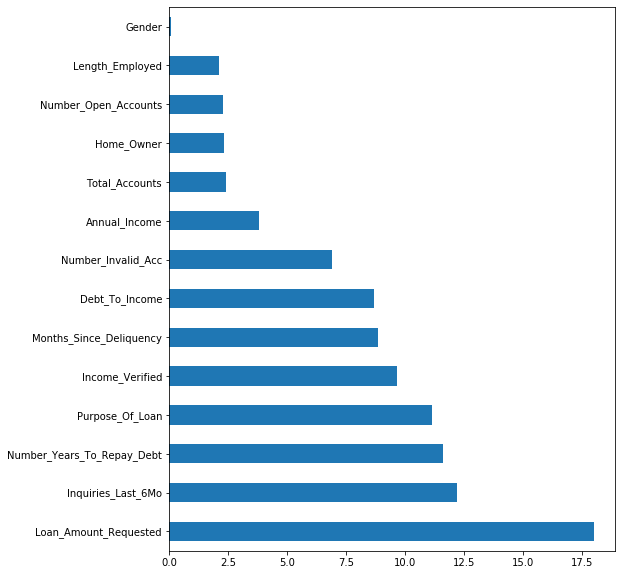

In [23]:
feat_imp = pd.Series(model.feature_importances_, index=df_train.drop(["Interest_Rate"], axis=1).columns)
feat_imp.nlargest(30).plot(kind='barh', figsize=(8,10))

# LIGHTGBM

### Pre-processing specific to LightGBM

In [14]:
df_train = pd.read_csv("train_fNxu4vz.csv")
df_test = pd.read_csv("test_fjtUOL8.csv")

# Convert to numeric
df_train["Loan_Amount_Requested"] = df_train["Loan_Amount_Requested"].str.replace(",", "")
df_train["Loan_Amount_Requested"] = pd.to_numeric(df_train["Loan_Amount_Requested"])
df_test["Loan_Amount_Requested"] = df_test["Loan_Amount_Requested"].str.replace(",", "")
df_test["Loan_Amount_Requested"] = pd.to_numeric(df_test["Loan_Amount_Requested"])

# Fill NaN
df_train["Length_Employed"].fillna('NaN', inplace=True)
df_test["Length_Employed"].fillna('NaN', inplace=True)

df_train["Home_Owner"].fillna('NaN', inplace=True)
df_test["Home_Owner"].fillna('NaN', inplace=True)

df_train["Purpose_Of_Loan"].fillna('NaN', inplace=True)
df_test["Purpose_Of_Loan"].fillna('NaN', inplace=True)

df_train["Gender"].fillna('NaN', inplace=True)
df_test["Gender"].fillna('NaN', inplace=True)

# Drop loan ids
df_train = df_train.drop(["Loan_ID"], axis=1)
loan_ids = df_test["Loan_ID"].values
df_test = df_test.drop(["Loan_ID"], axis=1)

# Label Encode
le = LabelEncoder()
df_train["Length_Employed"] = le.fit_transform(df_train["Length_Employed"])
df_test["Length_Employed"] = le.transform(df_test["Length_Employed"])

df_train["Home_Owner"] = le.fit_transform(df_train["Home_Owner"])
df_test["Home_Owner"] = le.transform(df_test["Home_Owner"])

df_train["Income_Verified"] = le.fit_transform(df_train["Income_Verified"])
df_test["Income_Verified"] = le.transform(df_test["Income_Verified"])

df_train["Purpose_Of_Loan"] = le.fit_transform(df_train["Purpose_Of_Loan"])
df_test["Purpose_Of_Loan"] = le.transform(df_test["Purpose_Of_Loan"])

df_train["Gender"] = le.fit_transform(df_train["Gender"])
df_test["Gender"] = le.transform(df_test["Gender"])

# Fill NaN with mean
df_train["Annual_Income"].fillna(df_train["Annual_Income"].mean(), inplace=True)
df_test["Annual_Income"].fillna(df_test["Annual_Income"].mean(), inplace=True)

# Assumption: If it is NaN, then user has no deliquency, so set with 0
df_train["Months_Since_Deliquency"].fillna(0, inplace=True)
df_test["Months_Since_Deliquency"].fillna(0, inplace=True)

# New feature
df_train["Number_Invalid_Acc"] = df_train["Total_Accounts"] - df_train["Number_Open_Accounts"]
df_test["Number_Invalid_Acc"] = df_test["Total_Accounts"] - df_test["Number_Open_Accounts"]

# New feature
df_train["Number_Years_To_Repay_Debt"] = df_train["Loan_Amount_Requested"]/df_train["Annual_Income"]
df_test["Number_Years_To_Repay_Debt"] = df_test["Loan_Amount_Requested"]/df_test["Annual_Income"]

df_train.head()

,Loan_Amount_Requested,Length_Employed,Home_Owner,Annual_Income,Income_Verified,Purpose_Of_Loan,Debt_To_Income,Inquiries_Last_6Mo,Months_Since_Deliquency,Number_Open_Accounts,Total_Accounts,Gender,Interest_Rate,Number_Invalid_Acc,Number_Years_To_Repay_Debt
0,7000,10,5,68000.000000,2,0,18.37,0,0.0,9,14,0,1,5,0.102941
1,30000,4,0,73331.159434,0,2,14.93,0,17.0,12,24,0,3,12,0.409103
2,24725,7,0,75566.400000,1,2,15.88,0,0.0,12,16,1,3,4,0.327196
3,16000,10,1,56160.000000,1,2,14.34,3,0.0,16,22,1,3,6,0.284900
4,17000,8,4,96000.000000,1,2,22.17,1,0.0,19,30,0,1,11,0.177083


### Convert to X and Y

In [15]:
X_train, Y = df_train.drop(["Interest_Rate"], axis=1).values, df_train["Interest_Rate"].values
X_test = df_test.values

X_train.shape, Y.shape, X_test.shape

((164309, 14), (164309,), (109541, 14))

### Perform Validation

In [16]:
kfold, scores = KFold(n_splits=5, shuffle=True, random_state=0), list()
for train, test in kfold.split(X_train):
    x_train, x_test = X_train[train], X_train[test]
    y_train, y_test = Y[train], Y[test]
    
    num_class1, num_class2, num_class3 = Counter(y_train)[1], Counter(y_train)[2], Counter(y_train)[3]
    sm = SMOTE(random_state=27, sampling_strategy={1: int(2.0*num_class1), 2: int(1.6*num_class2), 3: int(1.6*num_class3)})
    x_train, y_train = sm.fit_resample(x_train, y_train)
    
    model = LGBMClassifier(random_state=27, max_depth=6, n_estimators=400)
    model.fit(x_train, y_train, categorical_feature=[1, 2, 4, 5, 11])
    preds = model.predict(x_test)
    score = f1_score(y_test, preds, average="weighted")
    scores.append(score)
    print(score)
print("Average: ", sum(scores)/len(scores))

0.5364962372509364
0.5337692541119526
0.5332167074343459
0.5354353011823852
0.5371455480768109
Average:  0.5352126096112861


### Make final prediction using Lightgbm

In [17]:
# We apply SMOTE on all classes, thus increasing total sample size of each class
# This generalizes the decision boundary
num_class1, num_class2, num_class3 = Counter(Y)[1], Counter(Y)[2], Counter(Y)[3]
sm = SMOTE(random_state=27, sampling_strategy={1: int(2.0*num_class1), 2: int(1.6*num_class2), 3: int(1.6*num_class3)})
X_train_, Y_ = sm.fit_resample(X_train, Y)

model = LGBMClassifier(random_state=27, max_depth=6, n_estimators=400)
model.fit(X_train_, Y_, categorical_feature=[1, 2, 4, 5, 11])
preds2 = model.predict_proba(X_test)

### Check Feature Importance

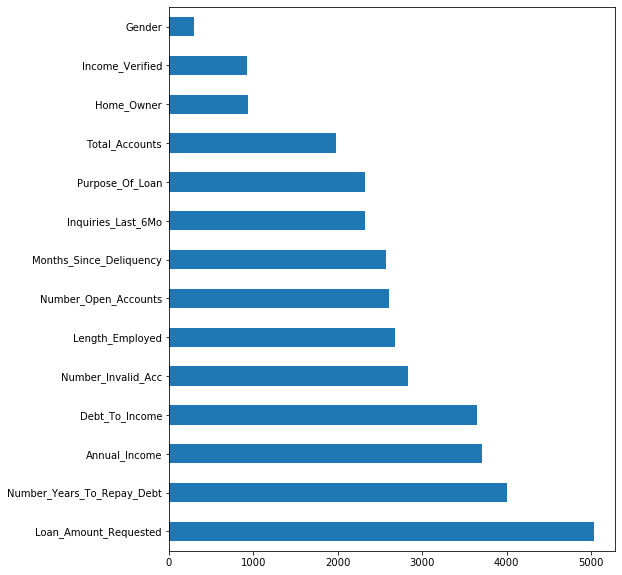

In [18]:
feat_imp = pd.Series(model.feature_importances_, index=df_train.drop(["Interest_Rate"], axis=1).columns)
feat_imp.nlargest(30).plot(kind='barh', figsize=(8,10))

### Ensembling

In [24]:
preds = list()
cb_weight=0.4 # Catboost
lb_weight=0.6 # LGBM
for i, j in zip(preds1, preds2):
    xx = [(cb_weight * i[0]) + (lb_weight * j[0]),
          (cb_weight * i[1]) + (lb_weight * j[1]),
          (cb_weight * i[2]) + (lb_weight * j[2])]
    preds.append(xx)
print(preds[:10])
preds=np.argmax(preds,axis=1)+1

[[0.18386426964226404, 0.3909910366414895, 0.4251446937162464], [0.4777620315482567, 0.44860725220510544, 0.07363071624663786], [0.1449557114241491, 0.42887270085689116, 0.42617158771895974], [0.2047830279936917, 0.5097492638162919, 0.2854677081900163], [0.1104560616581047, 0.47527165238409913, 0.41427228595779614], [0.09513549578801096, 0.42101758331612893, 0.48384692089586], [0.0810944658992149, 0.3372308084525589, 0.5816747256482262], [0.027056544134038952, 0.1280071412164939, 0.8449363146494671], [0.060393040250912605, 0.2961985196471969, 0.6434084401018905], [0.05780007807570865, 0.33576710140662513, 0.6064328205176662]]


### Make the final submission

In [25]:
# df_submit = pd.DataFrame({'Loan_ID': loan_ids, 'Interest_Rate': np.argmax(preds1, axis=1)+1}) # CB submission
# df_submit = pd.DataFrame({'Loan_ID': loan_ids, 'Interest_Rate': np.argmax(preds2, axis=1)+1}) # LGBM submission
df_submit = pd.DataFrame({'Loan_ID': loan_ids, 'Interest_Rate': preds}) # Ensemble submission
df_submit.to_csv("submit1.csv", index=False)